# LendingTree Loan Data Cleaning and Modeling
---


## Setup and Imports

### TODO
  - Include test samples in repo to reduce EDA effort
  - Clean up, tweak, feature engineering
  - Consider an analysis w/out interest rate, which could be considered leaky data
*


In [ ]:
import warnings
import logging
from pathlib import Path
from collections import Counter
import io

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from google.colab import drive

import numpy as np

# Suppress warnings and show all columns
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

## Data Loading

In [ ]:
drive.mount('/content/drive')
# 1.5 Gb
original_file = '/content/drive/MyDrive/sample_data/ltree/accepted_2007_to_2018Q4.csv'

df=pd.read_csv(original_file,low_memory=False)
print(df.shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(2260701, 151)


## Initial Exploration

In [ ]:
# Create binary field for loan status we can train against, drop field

# Drop NULL loan status rows and print remaining unique values list
print(sorted(df["loan_status"].dropna().unique().tolist()))
#Map to 0 or 1, 1= good, 0=bad
loan_status_mapping = {
    'Fully Paid': 1,
    'Current': 1,
    'In Grace Period': 1,
    'Late (16-30 days)': 0,
    'Does not meet the credit policy. Status:Charged Off' : 0,
    'Does not meet the credit policy. Status:Fully Paid' : 1,
    'Late (31-120 days)': 0,
    'Charged Off': 0,
    'Default': 0
}

# Apply the mapping to the 'Loan_Status' column
df['loan_status_binary'] = df['loan_status'].map(loan_status_mapping)
df.drop('loan_status', axis=1, inplace=True)
print(f"Created new binary LOAN_STATUS column (loan_status_binary)")

df['loan_status_binary'].value_counts()

['Charged Off', 'Current', 'Default', 'Does not meet the credit policy. Status:Charged Off', 'Does not meet the credit policy. Status:Fully Paid', 'Fully Paid', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']
Created new binary LOAN_STATUS column (loan_status_binary)


,count
loan_status_binary,
1.00,1965492
0.00,295176



⭐ DataFrame Shape:
(2260701, 151)

⭐ Data Types:
float64    114
object      37
Name: count, dtype: int64

⭐ First 5 Rows:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status_binary
0,68407277,NaN,3600.00,3600.00,3600.00,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.00,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.00,Aug-2003,675.00,679.00,1.00,30.00,NaN,7.00,0.00,2765.00,29.70,13.00,w,0.00,0.00,4421.72,4421.72,3600.00,821.72,0.00,0.00,0.00,Jan-2019,122.67,NaN,Mar-2019,564.00,560.00,0.00,30.00,1.00,Individual,NaN,NaN,NaN,0.00,722.00,144904.00,2.00,2.00,0.00,1.00,21.00,4981.00,36.00,3.00,3.00,722.00,34.00,9300.00,3.00,1.00,4.00,4.00,20701.00,1506.00,37.20,0.00,0.00,148.00,128.00,3.00,3.00,1.00,4.00,69.00,4.00,69.00,2.00,2.00,4.00,2.00,5.00,3.00,4.00,9.00,4.00,7.00,0.00,0.00,0.00,3.00,76.90,0.00,0.00,0.00,178050.00,7746.00,2400.00,13734.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1.00
1,68355089,NaN,24700.00,24700.00,24700.00,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.00,Not Verified,Dec-2015,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.00,Dec-1999,715.00,719.00,4.00,6.00,NaN,22.00,0.00,21470.00,19.20,38.00,w,0.00,0.00,25679.66,25679.66,24700.00,979.66,0.00,0.00,0.00,Jun-2016,926.35,NaN,Mar-2019,699.00,695.00,0.00,NaN,1.00,Individual,NaN,NaN,NaN,0.00,0.00,204396.00,1.00,1.00,0.00,1.00,19.00,18005.00,73.00,2.00,3.00,6472.00,29.00,111800.00,0.00,0.00,6.00,4.00,9733.00,57830.00,27.10,0.00,0.00,113.00,192.00,2.00,2.00,4.00,2.00,NaN,0.00,6.00,0.00,5.00,5.00,13.00


⭐ Info Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to loan_status_binary
dtypes: float64(114), object(37)
memory usage: 2.5+ GB


None


⭐ Describe Numeric Features:


,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term,loan_status_binary
count,0.00,2260668.00,2260668.00,2260668.00,2260668.00,2260668.00,2260664.00,2258957.00,2260639.00,2260668.00,2260668.00,2260638.00,1102166.00,359156.00,2260639.00,2260639.00,2260668.00,2258866.00,2260639.00,2260668.00,2260668.00,2260668.00,2260668.00,2260668.00,2260668.00,2260668.00,2260668.00,2260668.00,2260668.00,2260668.00,2260668.00,2260523.00,580775.00,2260668.00,120710.00,120706.00,2260639.00,2190392.00,2190392.00,1394538.00,1394539.00,1394539.00,1394539.00,1350744.00,1394539.00,1191818.00,1394539.00,1394539.00,1394539.00,1394320.00,2190392.00,1394539.00,1394538.00,1394538.00,2210638.00,2190322.00,2185733.00,2184597.00,2260523.00,2260639.00,2121597.00,2190391.00,2190391.00,2190392.00,2210638.00,2187256.00,519701.00,1965233.00,740359.00,2190392.00,2190392.00,2190392.00,2202078.00,2190392.00,2190392.00,2190392.00,2190391.00,2190392.00,2202078.00,2107011.00,2190392.00,2190392.00,2190392.00,2190237.00,2185289.00,2259303.00,2260563.00,2190392.00,2210638.00,2210638.00,2190392.00,108020.00,108021.00,108021.00,108021.00,108021.00,108021.00,106184.00,108021.00,108021.00,108021.00,108021.00,35942.00,10917.00,10917.00,10917.00,10917.00,8651.00,10917.00,10917.00,34246.00,34246.00,34246.00,2260668.00
mean,NaN,15046.93,15041.66,15023.44,13.09,445.81,77992.43,18.82,0.31,698.59,702.59,0.58,34.54,72.31,11.61,0.20,16658.46,50.34,24.16,4206.89,4205.97,12082.56,12064.39,9505.77,2431.39,1.52,143.88,23.98,3429.35,687.66,675.54,0.02,44.16,1.00,123624.64,19.25,0.00,232.73,142492.20,0.93,2.78,0.68,1.56,21.22,35506.65,69.14,1.29,2.75,5806.39,57.03,34573.94,1.01,1.48,2.04,4.52,13547.80,11394.26,57.90,0.01,12.37,125.74,181.49,14.02,8.30,1.56,24.84,39.30,7.02,35.78,0.50,3.68,5.63,4.77,7.73,8.41,8.25,14.00,5.58,11.63,0.00,0.00,0.08,2.08,94.11,42.44,0.13,0.05,178242.75,51022.94,23193.77,43732.01,33617.28,669.76,673.76,0.63,1.54,11.47,58.17,3.01,12.53,0.05,0.08,36.94,3.00,155.05,3.00,13.74,454.80,11636.88,193.99,5010.66,47.78,13.19,0.87
std,NaN,9190.25,9188.41,9192.33,4.83,267.17,112696.20,14.18,0.87,33.01,33.01,0.89,21.90,26.46,5.64,0.57,22948.31,24.71,11.99,7343.24,7342.33,9901.38,9896.99,832


⭐ Describe Categorical Features:


,id,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type,verification_status_joint,sec_app_earliest_cr_line,hardship_flag,hardship_type,hardship_reason,hardship_status,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_loan_status,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date
count,2260701,2260668,2260668,2260668,2093699,2113761,2260668,2260668,2260668,2260668,2260668,126065,2260668,2237342,2260667,2260668,2260639,2260668,2258241,915358,2260596,2260668,115730,108021,2260668,10917,10917,10917,10917,10917,10917,10917,2260668,2260668,34246,34246,34246
unique,2260701,2,7,35,512694,11,6,3,139,2,2260668,124500,14,63154,956,51,754,2,136,106,141,2,3,663,2,1,9,3,27,28,27,5,2,2,83,3,90
top,Total amount funded in policy code 2: 521953170,36 months,B,C1,Teacher,10+ years,MORTGAGE,Source Verified,Mar-2016,n,https://lendingclub.com/browse/loanDetail.acti...,,debt_consolidation,Debt consolidation,112xx,CA,Sep-2004,w,Mar-2019,Apr-2019,Mar-2019,Individual,Not Verified,Aug-2006,N,INTEREST ONLY-3 MONTHS DEFERRAL,NATURAL_DISASTER,COMPLETED,Sep-2017,Dec-2017,Sep-2017,Late (16-30 days),Cash,N,Feb-2019,ACTIVE,Jan-2019
freq,1,1609754,663557,145903,38824,748005,1111450,886231,61992,2260048,1,252,1277877,1153293,23908,314533,15400,1535467,853003,912221,1371381,2139958,57403,998,2259836,10917,2965,7819,2444,1756,1715,4770,2182546,2226422,2606,14704,1710



⭐ Missing Values Per Column:


,0
member_id,2260701
orig_projected_additional_accrued_interest,2252050
hardship_last_payment_amount,2249784
hardship_length,2249784
payment_plan_start_date,2249784
...,...
total_rec_int,33
hardship_flag,33
disbursement_method,33
debt_settlement_flag,33



⭐ Number of Duplicated Rows:
0

⭐ Unique Values Per Column:


,0
id,2260701
member_id,0
loan_amnt,1572
funded_amnt,1572
funded_amnt_inv,10057
...,...
settlement_date,90
settlement_amount,21941
settlement_percentage,2070
settlement_term,40



⭐ Missing Values Heatmap:


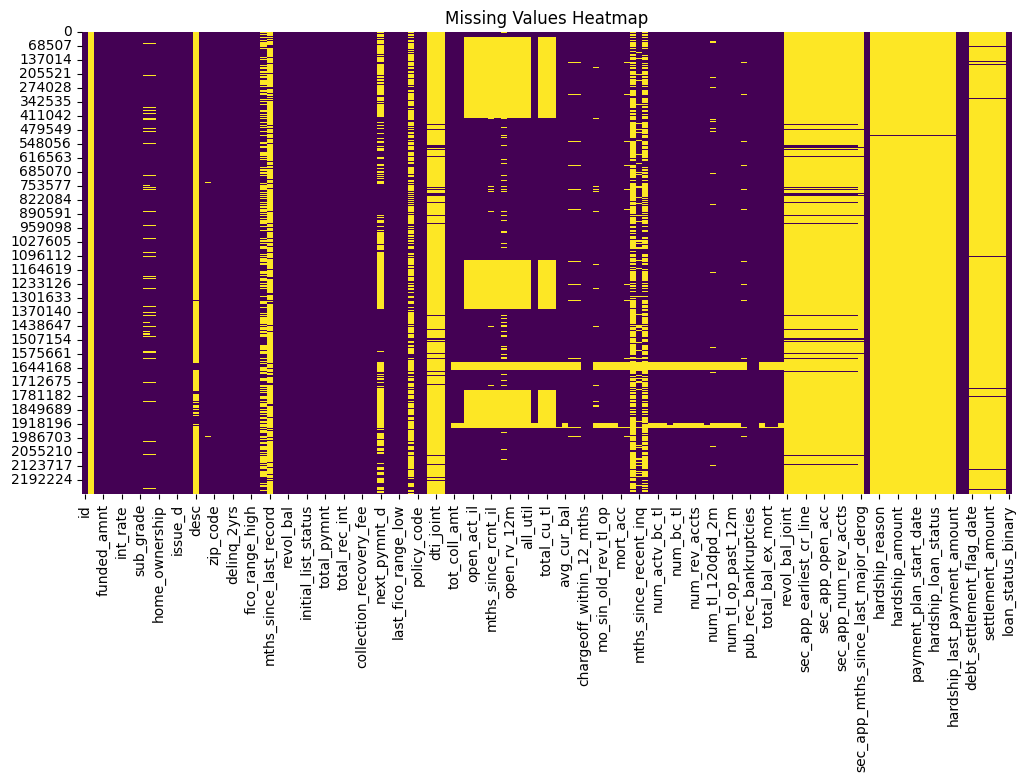


⭐ Target Variable (loan_status_binary) Distribution:


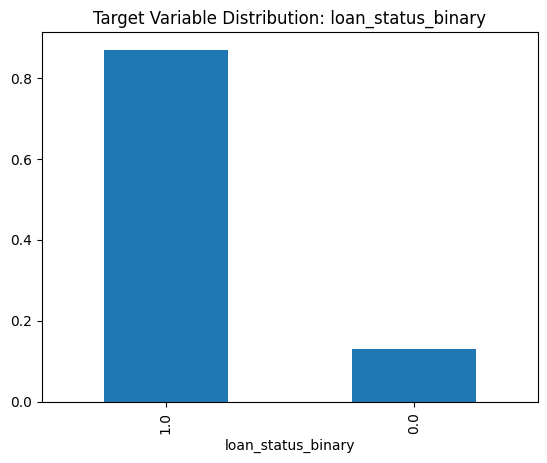

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
def basic_eda(df, target_col=None):
    print("\n\u2b50 DataFrame Shape:")
    print(df.shape)

    print("\n\u2b50 Data Types:")
    print(df.dtypes.value_counts())

    print("\n\u2b50 First 5 Rows:")
    display(df.head())

    print("\n\u2b50 Info Summary:")
    display(df.info())

    print("\n\u2b50 Describe Numeric Features:")
    display(df.describe())

    print("\n\u2b50 Describe Categorical Features:")
    display(df.describe(include='O'))

    print("\n\u2b50 Missing Values Per Column:")
    missing = df.isnull().sum()
    display(missing[missing > 0].sort_values(ascending=False))

    print("\n\u2b50 Number of Duplicated Rows:")
    print(df.duplicated().sum())

    print("\n\u2b50 Unique Values Per Column:")
    display(df.nunique())

    print("\n\u2b50 Missing Values Heatmap:")
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Values Heatmap')
    plt.show()

    if target_col:
        print(f"\n\u2b50 Target Variable ({target_col}) Distribution:")
        df[target_col].value_counts(normalize=True).plot(kind='bar')
        plt.title(f'Target Variable Distribution: {target_col}')
        plt.show()


basic_eda(df, target_col='loan_status_binary')

## Data Cleaning and Preprocessing

In [ ]:
# Remove leading/trailing whitespaces from objects and strings
df = df.apply(lambda col: col.str.strip() if col.dtypes == 'object' or col.dtypes == 'string' else col)

In [ ]:
# Convert, and impute missing emp_length with mode
emp_length_mapping = {
  '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
  '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10
}

df['emp_length'] = df['emp_length'].map(emp_length_mapping)
emp_length_mode = df['emp_length'].mode()[0]
df['emp_length'] = df['emp_length'].fillna(emp_length_mode)

In [ ]:
# Home_ownership: Condense, OHE & drop original category

# Work only on 'home_ownership' column
home_ownership_temp = df['home_ownership'].replace({'ANY': 'OTHER', 'NONE': 'OTHER'})

# One-hot encode
home_ownership_dummies = pd.get_dummies(home_ownership_temp, prefix='home_ownership')

# Join the new dummies to original dataframe
df = pd.concat([df, home_ownership_dummies], axis=1)

# Drop original 'home_ownership',  no longer needed since OHE
df.drop(columns=['home_ownership'], inplace=True)


In [ ]:
# Verification_status: One-hot encode & drop original category
verification_dummies = pd.get_dummies(df['verification_status'], prefix='verification_status')
df = pd.concat([df, verification_dummies], axis=1)
df = df.drop('verification_status', axis=1)

In [ ]:
# Columns with ~3% nulls to impute with 0 - assuming these likely represent new
# borrowers and could be important
cols_to_impute_zero = [
    'acc_open_past_24mths', 'mort_acc', 'total_bal_ex_mort',
    'mo_sin_rcnt_tl', 'tot_coll_amt', 'num_actv_rev_tl',
    'tot_hi_cred_lim', 'num_tl_op_past_12m', 'num_tl_90g_dpd_24m',
    'num_accts_ever_120_pd', 'num_il_tl', 'total_rev_hi_lim',
    'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'num_rev_accts',
    'avg_cur_bal', 'pct_tl_nvr_dlq', 'bc_open_to_buy', 'percent_bc_gt_75'
]


# Impute all with 0
for col in cols_to_impute_zero:
    df[col].fillna(0, inplace=True)

print(f"Imputed 0 for these columns: {cols_to_impute_zero}")


Imputed 0 for these columns: ['acc_open_past_24mths', 'mort_acc', 'total_bal_ex_mort', 'mo_sin_rcnt_tl', 'tot_coll_amt', 'num_actv_rev_tl', 'tot_hi_cred_lim', 'num_tl_op_past_12m', 'num_tl_90g_dpd_24m', 'num_accts_ever_120_pd', 'num_il_tl', 'total_rev_hi_lim', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'num_rev_accts', 'avg_cur_bal', 'pct_tl_nvr_dlq', 'bc_open_to_buy', 'percent_bc_gt_75']


In [ ]:
# purpose: Condense rare categories, OHE and drop original category
purpose_counts = Counter(df['purpose'])
total_count = len(df)
rare_threshold = 0.05 * total_count
# Replace rare categories with 'other'
df['purpose'] = df['purpose'].apply(
    lambda x: x if purpose_counts[x] >= rare_threshold else 'other'
)
purpose_dummies = pd.get_dummies(df['purpose'], prefix='purpose')
df = pd.concat([df, purpose_dummies], axis=1)
df = df.drop('purpose', axis=1)

In [ ]:
# Drop highly correlated (from previous analysis)
drop_high_correlation={'funded_amnt_inv', 'total_bal_il', 'total_pymnt', 'num_rev_tl_bal_gt_0',
       'num_sats', 'num_op_rev_tl', 'total_bc_limit',
      'total_il_high_credit_limit','num_bc_tl',
      'out_prncp_inv', 'out_prncp' ,'num_tl_30dpd', 'bc_util', 'tot_cur_bal',
      'num_actv_bc_tl', 'open_acc', 'funded_amnt',
      'collection_recovery_fee', 'total_pymnt_inv',
      'revol_bal', 'grade'}
df.drop(drop_high_correlation,axis=1, inplace=True)

print(f"Dropped columns with HIGH CORRELATION: {list(drop_high_correlation)}")

Dropped columns with HIGH CORRELATION: ['open_acc', 'total_il_high_credit_limit', 'revol_bal', 'funded_amnt_inv', 'out_prncp_inv', 'total_bc_limit', 'funded_amnt', 'tot_cur_bal', 'num_rev_tl_bal_gt_0', 'total_bal_il', 'total_pymnt', 'grade', 'bc_util', 'collection_recovery_fee', 'total_pymnt_inv', 'num_actv_bc_tl', 'out_prncp', 'num_tl_30dpd', 'num_sats', 'num_op_rev_tl', 'num_bc_tl']


In [ ]:
# Drop redundant features
features_to_drop = ['term', 'num_bc_sats']
df = df.drop(columns=features_to_drop)
print(f"Dropped columns: {features_to_drop}")

Dropped columns: ['term', 'num_bc_sats']


In [ ]:
# Drop "leaky" features (post approval)
leaky_data_cols = {'last_fico_range_high','last_fico_range_low',
                   'fico_range_low', 'debt_settlement_flag',
                   'fico_range_high', 'acc_now_delinq',
                   'last_credit_pull_d','total_rec_prncp',
                   'total_rec_int', 'last_pymnt_amnt'  }
df.drop(leaky_data_cols , axis=1, inplace=True)

print(f"Dropped columns with LEAKY DATA: {list(leaky_data_cols)}")

Dropped columns with LEAKY DATA: ['debt_settlement_flag', 'last_pymnt_amnt', 'fico_range_low', 'last_fico_range_high', 'acc_now_delinq', 'fico_range_high', 'last_fico_range_low', 'total_rec_prncp', 'last_credit_pull_d', 'total_rec_int']


In [ ]:
 # Drop where IV < 0.02 (from previous analysis)
columns_to_drop= {'application_type','hardship_flag','earliest_cr_line','addr_state'}
df.drop(columns_to_drop, axis=1, inplace=True)

print(f"Dropped columns where IV < 0.02: {list(columns_to_drop)}")

Dropped columns where IV < 0.02: ['addr_state', 'hardship_flag', 'application_type', 'earliest_cr_line']


In [ ]:
# Function to define dropping columns based on % values
def missing_data_summary(df, threshold=0):
    """
    Summarizes missing data, showing count and percentage of missing values for each column.
    Filters columns based on a missing percentage threshold.

    Parameters:
        df (pd.DataFrame): The dataframe to analyze.
        threshold (float): The minimum percentage of missing data to include in the summary.

    Returns:
        pd.DataFrame: A summary of missing data.
    """
    return (pd.DataFrame(df.isna().sum())
            .reset_index()
            .rename(columns={'index': 'Column', 0: 'mis_count'})
            .query('mis_count > 0')  # Only include columns with missing values
            .assign(Missing_Percentage=lambda x: x['mis_count'] / df.shape[0] * 100)
            .query(f'Missing_Percentage > {threshold}')  # Filter by threshold
            .sort_values('mis_count', ascending=False)
            .reset_index(drop=True))

# Get columns with 45% or more of their data missing
missing = missing_data_summary(df,45)
missing

,Column,mis_count,Missing_Percentage
0,member_id,2260701,100.00
1,orig_projected_additional_accrued_interest,2252050,99.62
2,payment_plan_start_date,2249784,99.52
3,hardship_dpd,2249784,99.52
4,hardship_length,2249784,99.52
5,deferral_term,2249784,99.52
6,hardship_last_payment_amount,2249784,99.52
7,hardship_end_date,2249784,99.52
8,hardship_start_date,2249784,99.52
9,hardship_reason,2249784,99.52


In [ ]:
print("Null counts and percentages for columns with missing values < 15% (sorted by percentage):")
# Identify columns with 15% or more missing values (from the original null_info for consistency)

# Calculate the null counts and percentages
null_info = pd.DataFrame({
    'null_count': df.isnull().sum(),
    'null_percentage': df.isnull().sum() / len(df) * 100
})
cols_to_drop = null_info[null_info['null_percentage'] >= 15].index.tolist()



Null counts and percentages for columns with missing values < 15% (sorted by percentage):


In [ ]:
# Drop columns with > 15% missing values
df.drop(cols_to_drop, axis=1, inplace=True)

print("Dropped columns with 15% or more missing values:")
for col in cols_to_drop:
    print(col)

Dropped columns with 15% or more missing values:
member_id
desc
mths_since_last_delinq
mths_since_last_record
next_pymnt_d
mths_since_last_major_derog
annual_inc_joint
dti_joint
verification_status_joint
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
inq_fi
total_cu_tl
inq_last_12m
mths_since_recent_bc_dlq
mths_since_recent_revol_delinq
revol_bal_joint
sec_app_fico_range_low
sec_app_fico_range_high
sec_app_earliest_cr_line
sec_app_inq_last_6mths
sec_app_mort_acc
sec_app_open_acc
sec_app_revol_util
sec_app_open_act_il
sec_app_num_rev_accts
sec_app_chargeoff_within_12_mths
sec_app_collections_12_mths_ex_med
sec_app_mths_since_last_major_derog
hardship_type
hardship_reason
hardship_status
deferral_term
hardship_amount
hardship_start_date
hardship_end_date
payment_plan_start_date
hardship_length
hardship_dpd
hardship_loan_status
orig_projected_additional_accrued_interest
hardship_payoff_balance_amount
hardship_last_pay

In [ ]:
# Drop NULL rows of those columsn that have 200 or fewer nulls.

# Identify columns with fewer than 200 null rows
cols_to_dropna = null_info[null_info['null_count'] < 200].index.tolist()

# Drop rows where any of the identified columns have a null value
df.dropna(subset=cols_to_dropna, inplace=True)

print(f"Dropped rows with null values in columns with fewer than 200 nulls: {cols_to_dropna}")



Dropped rows with null values in columns with fewer than 200 nulls: ['id', 'loan_amnt', 'int_rate', 'installment', 'sub_grade', 'emp_length', 'annual_inc', 'issue_d', 'pymnt_plan', 'url', 'zip_code', 'delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'total_acc', 'initial_list_status', 'total_rec_late_fee', 'recoveries', 'collections_12_mths_ex_med', 'policy_code', 'tot_coll_amt', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_rev_tl', 'num_il_tl', 'num_rev_accts', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'disbursement_method', 'loan_status_binary', 'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified',

In [ ]:
# Fill null values in 'pub_rec_bankruptcies' with 0
df['pub_rec_bankruptcies'].fillna(0, inplace=True)

print("Filled null values in 'pub_rec_bankruptcies' with 0.")

Filled null values in 'pub_rec_bankruptcies' with 0.


In [ ]:
# Outlier Handling
# Cap outliers using IQR method
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower=lower_bound, upper=upper_bound)


# Apply to numerical columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    if col not in ['grade', 'loan_status_binary']:  # Exclude ordinal and target
        df[col] = cap_outliers(df[col])

In [ ]:
# Impute missing DTI with the median
median_dti = df['dti'].median()
df['dti'].fillna(median_dti, inplace=True)


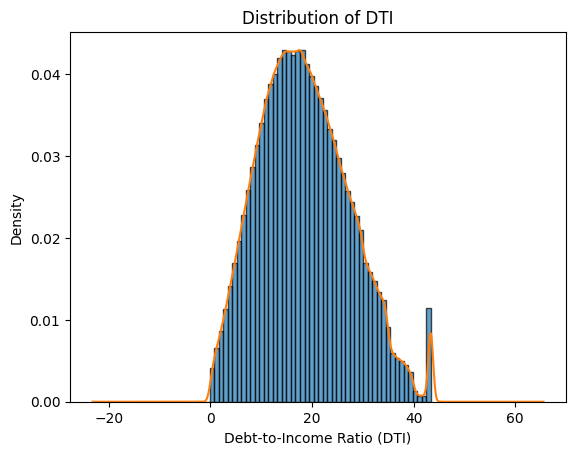

In [ ]:
plt.hist(df['dti'].dropna(), bins=50, edgecolor='k', alpha=0.7, density=True)
df['dti'].dropna().plot(kind='kde')  # Density plot
plt.xlabel('Debt-to-Income Ratio (DTI)')
plt.ylabel('Density')
plt.title('Distribution of DTI')
plt.show()


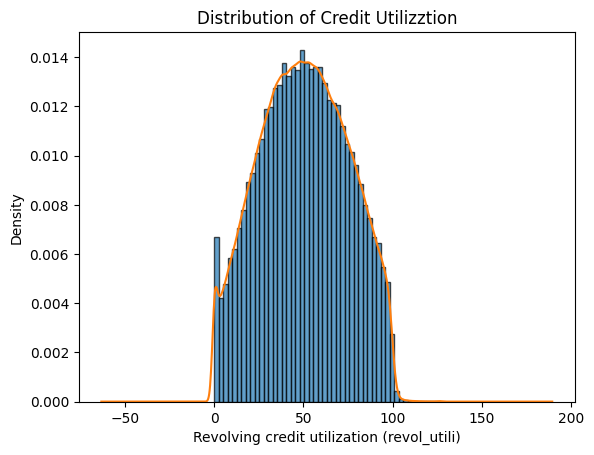

In [ ]:
plt.hist(df['revol_util'].dropna(), bins=50, edgecolor='k', alpha=0.7, density=True)
df['revol_util'].dropna().plot(kind='kde')  # Density plot
plt.xlabel('Revolving credit utilization (revol_utili)')
plt.ylabel('Density')
plt.title('Distribution of Credit Utilizztion')
plt.show()

In [ ]:
# Create an indicator column for missing revol_util
df['revol_util_missing'] = df['revol_util'].isna().astype(int)

# Fill NaNs with 0 — assume no revolving credit
df['revol_util'].fillna(0, inplace=True)

In [ ]:
# Columns with ~3% nulls to impute with 0 - assuming these likely represent new
# borrowers and could be important
cols_to_impute_zero = [
    'acc_open_past_24mths', 'mort_acc', 'total_bal_ex_mort',
    'mo_sin_rcnt_tl', 'tot_coll_amt', 'num_actv_rev_tl',
    'tot_hi_cred_lim', 'num_tl_op_past_12m', 'num_tl_90g_dpd_24m',
    'num_accts_ever_120_pd', 'num_il_tl', 'total_rev_hi_lim',
    'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'num_rev_accts',
    'avg_cur_bal', 'pct_tl_nvr_dlq', 'bc_open_to_buy', 'percent_bc_gt_75'
]


# Impute all with 0
for col in cols_to_impute_zero:
    df[col].fillna(0, inplace=True)

print(f"Imputed 0 for these columns: {cols_to_impute_zero}")


Imputed 0 for these columns: ['acc_open_past_24mths', 'mort_acc', 'total_bal_ex_mort', 'mo_sin_rcnt_tl', 'tot_coll_amt', 'num_actv_rev_tl', 'tot_hi_cred_lim', 'num_tl_op_past_12m', 'num_tl_90g_dpd_24m', 'num_accts_ever_120_pd', 'num_il_tl', 'total_rev_hi_lim', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'num_rev_accts', 'avg_cur_bal', 'pct_tl_nvr_dlq', 'bc_open_to_buy', 'percent_bc_gt_75']


In [ ]:
# Columns of questionable worth, dropping
cols_to_drop = [
    'title',
    'emp_title',
    'num_accts_ever_120_pd',
    'num_tl_90g_dpd_24m',
    'num_tl_120dpd_2m'
]

# Drop them
df.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped columns: {cols_to_drop}")


Dropped columns: ['title', 'emp_title', 'num_accts_ever_120_pd', 'num_tl_90g_dpd_24m', 'num_tl_120dpd_2m']


In [ ]:
# Better name percentage column, and recalculate (other % columns dropped later)
df.rename(columns={'int_rate%': 'int_rate'}, inplace=True)

# Convert percentage values to decimals
df['int_rate'] = df['int_rate'] / 100
df['pct_tl_nvr_dlq'] = df['pct_tl_nvr_dlq'] / 100
df['percent_bc_gt_75'] = df['percent_bc_gt_75'] / 100


In [ ]:
# List of columns to impute with mode
mode_impute_cols = [
    'emp_length', 'pymnt_plan', 'initial_list_status',
    'disbursement_method'
]

# Impute each column with its mode
for col in mode_impute_cols:
    mode_val = df[col].mode(dropna=True)[0]
    df[col].fillna(mode_val, inplace=True)

print(f"Imputed mode on NaN Values for {mode_impute_cols}")

Imputed mode on NaN Values for ['emp_length', 'pymnt_plan', 'initial_list_status', 'disbursement_method']


In [ ]:
def get_sorted_unique_counts(df):
    # Select columns with categorical data
    object_cols = df.select_dtypes(include=['object', 'category']).columns

    # Get the number of unique entries in each categorical column
    object_nunique = {col: df[col].nunique() for col in object_cols}

    # Convert to DataFrame and sort by unique counts
    unique_counts = pd.DataFrame(list(object_nunique.items()), columns=['Column', 'Unique Count'])
    unique_counts = unique_counts.sort_values(by='Unique Count').reset_index(drop=True)

    return unique_counts

# Get unique counts
unique_counts_df = get_sorted_unique_counts(df)
print(f"Unique value assessment {unique_counts_df}")


Unique value assessment                 Column  Unique Count
0           pymnt_plan             2
1  initial_list_status             2
2  disbursement_method             2
3            sub_grade            35
4         last_pymnt_d           136
5              issue_d           137
6             zip_code           956
7                   id       2260521
8                  url       2260521


In [ ]:
# Drop columns with unique count > 15
cols_to_drop = unique_counts_df[unique_counts_df['Unique Count'] > 15]['Column'].tolist()
df = df.drop(columns=cols_to_drop)

# Optional: show what was dropped
print(f"Dropped columns with unique values > 15: {cols_to_drop}")

Dropped columns with unique values > 15: ['sub_grade', 'last_pymnt_d', 'issue_d', 'zip_code', 'id', 'url']


In [ ]:
# Drop the sparsely populated columns
# Convert the first column of 'missing' to a list
columns_to_drop = missing.iloc[:, 0].tolist()

# Drop these columns from the DataFrame 'df'
df = df.drop(columns=columns_to_drop, errors='ignore')  # 'errors="ignore"' ensures no error if a column is missing

print(f"Dropped columns missing 45% of their data: {list(columns_to_drop)}")

Dropped columns missing 45% of their data: ['member_id', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'hardship_dpd', 'hardship_length', 'deferral_term', 'hardship_last_payment_amount', 'hardship_end_date', 'hardship_start_date', 'hardship_reason', 'hardship_status', 'hardship_type', 'hardship_loan_status', 'hardship_amount', 'hardship_payoff_balance_amount', 'settlement_percentage', 'settlement_term', 'settlement_date', 'settlement_amount', 'settlement_status', 'debt_settlement_flag_date', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'revol_bal_joint', 'sec_app_collections_12_mths_ex_med', 'sec_app_fico_range_low', 'sec_app_earliest_cr_line', 'sec_app_chargeoff_within_12_mths', 'sec_app_num_rev_accts', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_fico_range_high', 'sec_app_open_act_il', 'verification_status_joint', 'dti_joint', 'annual_inc_joint', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mt

In [ ]:
# Drop zero variance values
numerical_variance = df.var(numeric_only=True)
print(numerical_variance)

zero_variance_cols = numerical_variance[numerical_variance == 0].index

df = df.drop(columns=zero_variance_cols)

print(f"Dropped columns with ZERO VARIANCE: {list(zero_variance_cols)}")

loan_amnt                                83007869.41
int_rate                                        0.00
installment                                 66562.06
emp_length                                     13.95
annual_inc                             1362213950.01
dti                                            78.31
delinq_2yrs                                     0.00
inq_last_6mths                                  0.58
pub_rec                                         0.00
revol_util                                    611.74
total_acc                                     131.20
total_rec_late_fee                              0.00
recoveries                                      0.00
collections_12_mths_ex_med                      0.00
policy_code                                     0.00
tot_coll_amt                                    0.00
total_rev_hi_lim                        518728312.32
acc_open_past_24mths                            8.67
avg_cur_bal                             144116

In [ ]:
# For mths_since_recent_inq: Create missing flag + impute with a large value
df['mths_since_recent_inq_missing'] = df['mths_since_recent_inq'].isna().astype(int)
df['mths_since_recent_inq'].fillna(999, inplace=True) # Use a value outside the normal range

# For mo_sin_old_il_acct: Create missing flag + impute with 0
df['mo_sin_old_il_acct_missing'] = df['mo_sin_old_il_acct'].isna().astype(int)
df['mo_sin_old_il_acct'].fillna(0, inplace=True)

# For mths_since_recent_bc: Impute with 0
df['mths_since_recent_bc'].fillna(0, inplace=True)

print("Handled missing values for mths_since_recent_inq, mo_sin_old_il_acct, and mths_since_recent_bc.")

Handled missing values for mths_since_recent_inq, mo_sin_old_il_acct, and mths_since_recent_bc.


In [ ]:
# Convert remaining categorical fields to numerical


# Define binary mapping for label encoding
binary_mappings = {
    'pymnt_plan': {'n': 0, 'y': 1},
    'initial_list_status': {'f': 0, 'w': 1}
}

# Apply label encoding to binary categorical columns
for column, mapping in binary_mappings.items():
    df[column] = df[column].map(mapping)

# Apply one-hot encoding to disbursement_method
df = pd.get_dummies(df, columns=['disbursement_method'], prefix='disbursement_method', drop_first=True)

# Verify the changes
print("Columns after encoding:")
print(df.dtypes)

Columns after encoding:
loan_amnt                              float64
int_rate                               float64
installment                            float64
emp_length                             float64
annual_inc                             float64
pymnt_plan                               int64
dti                                    float64
inq_last_6mths                         float64
revol_util                             float64
total_acc                              float64
initial_list_status                      int64
total_rev_hi_lim                       float64
acc_open_past_24mths                   float64
avg_cur_bal                            float64
bc_open_to_buy                         float64
mo_sin_old_il_acct                     float64
mo_sin_old_rev_tl_op                   float64
mo_sin_rcnt_rev_tl_op                  float64
mo_sin_rcnt_tl                         float64
mort_acc                               float64
mths_since_recent_bc                

## Feature Engineering

In [ ]:
# Debt-to-Income Ratio:
df['dti_ratio'] = df['loan_amnt'] / df['annual_inc']

In [ ]:
# Payment-to-Income Ratio
df['installment_to_income'] = df['installment'] / (df['annual_inc'] / 12)

In [ ]:
# Group borrowers by risk level using interest rate:
df['int_rate_bin'] = pd.qcut(df['int_rate'], q=5, labels=False)

In [ ]:
# Convert boolean columns to binary (OHE, e.g.)
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

In [ ]:
# Convert boolean columns to binary (OHE, e.g.)
df['disbursement_method_DirectPay'] = df['disbursement_method_DirectPay'].astype(int)

In [ ]:
# Redefine num_cols as all numeric columns - this should be all cos, but
# just in case.
num_cols = df.select_dtypes(include=['number']).columns.tolist()

# Point-biserial correlation for loan_status_binary vs numerical features
target = 'loan_status_binary'
pbc_corrs = {}
for col in df.columns:
    if col != target:
        corr, _ = pointbiserialr(df[target], df[col])
        pbc_corrs[col] = corr
print("Point-biserial correlations with loan_status_binary:\n", pbc_corrs)

# Scaling
scaler = StandardScaler()



# Exclude binary, ordinal, and target from scaling
scale_cols = [col for col in num_cols if col not in ['loan_status_binary'] + list(bool_cols)]

# Replace inf/-inf with NaN
df[scale_cols] = df[scale_cols].replace([np.inf, -np.inf], np.nan)

#  Now safely scale
df[scale_cols] = scaler.fit_transform(df[scale_cols])


# Check Class Balance
print("Class distribution of loan_status_binary:\n", df['loan_status_binary'].value_counts(normalize=True))

# Split full dataset
X = df.drop(columns=['loan_status_binary'])
y = df['loan_status_binary']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Take a 10% random subset for lazy/quick eval
df_small = df.sample(frac=0.10, random_state=42)

# Separate X and y for the smaller set
X_small = df_small.drop(columns=['loan_status_binary'])
y_small = df_small['loan_status_binary']

# Split small subset into train/test
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_small, y_small,
    test_size=0.2,  # 80/20 split
    stratify=y_small,
    random_state=42
)

# Define Google Drive path
drive_path = '/content/drive/MyDrive/sample_data/ltree/'

# Save processed data
X_train_full.to_csv(f'{drive_path}X_train_processed.csv', index=False)
X_test_full.to_csv(f'{drive_path}X_test_processed.csv', index=False)
y_train_full.to_csv(f'{drive_path}y_train.csv', index=False)
y_test_full.to_csv(f'{drive_path}y_test.csv', index=False)


# Save processed small data
X_train_small.to_csv(f'{drive_path}X_train_small_processed.csv', index=False)
X_test_small.to_csv(f'{drive_path}X_test_small_processed.csv', index=False)
y_train_small.to_csv(f'{drive_path}y_train_small.csv', index=False)
y_test_small.to_csv(f'{drive_path}y_test_small.csv', index=False)

print("Data preprocessing complete. Files saved.")

Point-biserial correlations with loan_status_binary:
 {'loan_amnt': np.float64(-0.027465877954438115), 'int_rate': np.float64(-0.20992471721297384), 'installment': np.float64(-0.032604632502659776), 'emp_length': np.float64(0.0026436745092819295), 'annual_inc': np.float64(0.05681662461492265), 'pymnt_plan': np.float64(-0.04250401467110719), 'dti': np.float64(-0.06327802142256418), 'inq_last_6mths': np.float64(-0.08511088031936255), 'revol_util': np.float64(-0.062180505303645627), 'total_acc': np.float64(-0.01284483662058787), 'initial_list_status': np.float64(0.061173601495103404), 'total_rev_hi_lim': np.float64(0.07131676862771599), 'acc_open_past_24mths': np.float64(-0.09171065294104463), 'avg_cur_bal': np.float64(0.06414733866287603), 'bc_open_to_buy': np.float64(0.09303694715823527), 'mo_sin_old_il_acct': np.float64(0.023829787791773662), 'mo_sin_old_rev_tl_op': np.float64(0.042186155464194665), 'mo_sin_rcnt_rev_tl_op': np.float64(0.06559127764959032), 'mo_sin_rcnt_tl': np.float64(

## Further Exploratory Data Analysis

## Modeling Preparation

In [ ]:
drive.mount('/content/drive')

# Pre-load splits if avaialble
drive_path = '/content/drive/MyDrive/sample_data/ltree/'

# Check and load only if not already loaded
if 'X_train_full' not in globals() or X_train_full is None:
    X_train_full = pd.read_csv(f'{drive_path}X_train_processed.csv')

if 'X_test_full' not in globals() or X_test_full is None:
    X_test_full = pd.read_csv(f'{drive_path}X_test_processed.csv')

if 'y_train_full' not in globals() or y_train_full is None:
    y_train_full = pd.read_csv(f'{drive_path}y_train.csv')

if 'y_test_full' not in globals() or y_test_full is None:
    y_test_full = pd.read_csv(f'{drive_path}y_test.csv')


Mounted at /content/drive


In [ ]:
# Pre-load splits if avaialble
drive_path = '/content/drive/MyDrive/sample_data/ltree/'

# Check and load only if not already loaded
if 'X_train_small' not in globals() or X_train_small is None:
    X_train_small = pd.read_csv(f'{drive_path}X_train_small_processed.csv')

if 'X_test_small' not in globals() or X_test_small is None:
    X_test_small = pd.read_csv(f'{drive_path}X_test_small_processed.csv')

if 'y_train_small' not in globals() or y_train_small is None:
    y_train_small = pd.read_csv(f'{drive_path}y_train_small.csv')

if 'y_test_small' not in globals() or y_test_small is None:
    y_test_small = pd.read_csv(f'{drive_path}y_test_small.csv')


## Modeling

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Define parameter space
param_dist = {
    'n_estimators': [100,200],
    'max_depth': [4, 8, 12, 16, 20],  # None = no max depth
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],  # How many features to consider at each split
}

# Randomized Search
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # How many combinations to try (more = better search)
    cv=3,       # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit search
rf_random.fit(X_train_full, y_train_full.values.ravel())

# Best model
best_rf = rf_random.best_estimator_

# Predict and Evaluate
y_pred = best_rf.predict(X_test_full)
r2 = r2_score(y_test_full, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_full, y_pred))

print(f'Best RandomForest R²: {r2:.4f}')
print(f'Best RandomForest RMSE: {rmse:.4f}')
print('Best Hyperparameters:', rf_random.best_params_)


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV


scale_pos_weight = np.sum(y_train_full == 0) / np.sum(y_train_full == 1)
scale_pos_weight = scale_pos_weight.item()

xgb_clf = XGBClassifier(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.6,
    colsample_bytree=0.6,
    min_child_weight=3,
    gamma=0.2,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Fit search
xgb_clf.fit(X_train_full, y_train_full.values.ravel())

# Best model
# best_model = random_search.best_estimator_

# Predict on test
y_pred_proba = xgb_clf.predict_proba(X_test_full)[:, 1]  # probabilities
y_pred = xgb_clf.predict(X_test_full)                    # hard classes

# Evaluate
auc = roc_auc_score(y_test_full, y_pred_proba)
accuracy = accuracy_score(y_test_full, y_pred)

# Since no random search, no best_params_ to print
print(f'ROC AUC Score: {auc:.4f}')
print(f'Accuracy Score: {accuracy:.4f}')


ROC AUC Score: 0.7278
Accuracy Score: 0.6415


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test_full, y_pred))
print(classification_report(y_test_full, y_pred))

[[ 41320  17710]
 [144349 248726]]
              precision    recall  f1-score   support

         0.0       0.22      0.70      0.34     59030
         1.0       0.93      0.63      0.75    393075

    accuracy                           0.64    452105
   macro avg       0.58      0.67      0.55    452105
weighted avg       0.84      0.64      0.70    452105



                             Feature  Importance
47                      int_rate_bin    0.113734
1                           int_rate    0.088207
44     disbursement_method_DirectPay    0.085668
5                         pymnt_plan    0.080032
34  verification_status_Not Verified    0.072278
12              acc_open_past_24mths    0.046426
33               home_ownership_RENT    0.039926
7                     inq_last_6mths    0.031399
10               initial_list_status    0.029628
45                         dti_ratio    0.025411
30           home_ownership_MORTGAGE    0.023751
14                    bc_open_to_buy    0.019014
25                num_tl_op_past_12m    0.015876
21             mths_since_recent_inq    0.014338
27                  percent_bc_gt_75    0.014151
28                   tot_hi_cred_lim    0.011883
36      verification_status_Verified    0.011869
37               purpose_credit_card    0.011810
13                       avg_cur_bal    0.011227
6                   

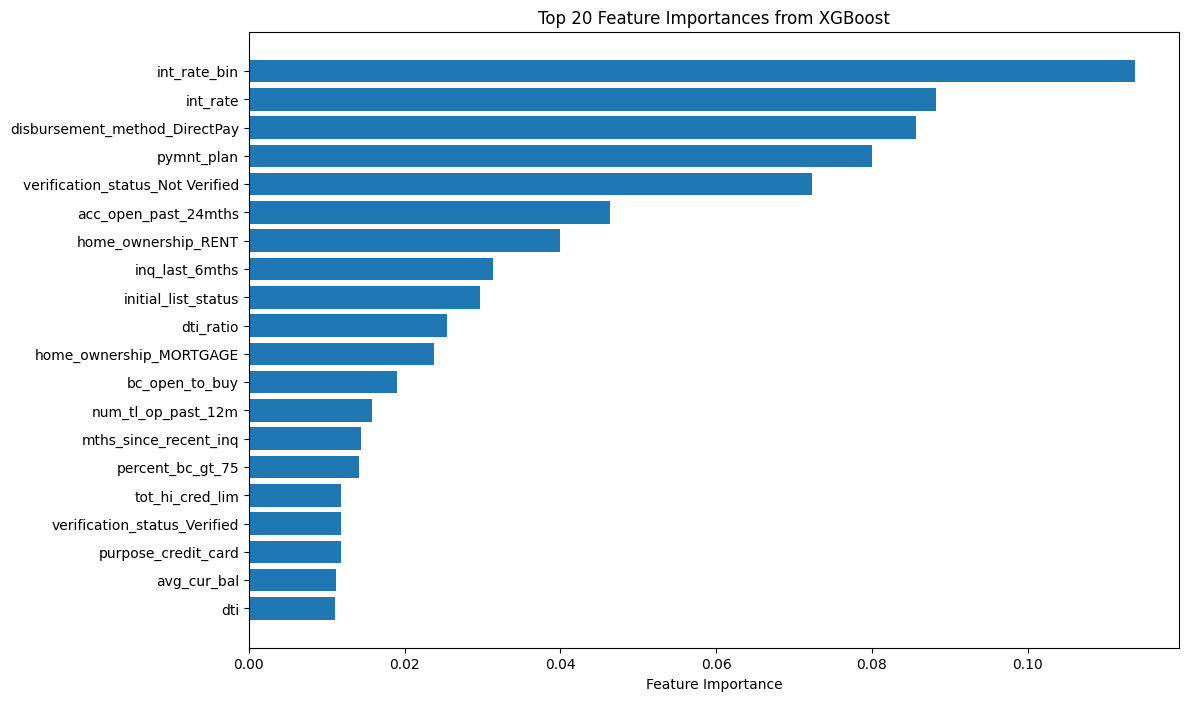

In [ ]:
# Get feature importance values
importances = best_model.feature_importances_
feature_names = X_train_full.columns

# Create a DataFrame for easier viewing
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances.head(20))  # Top 20 features

# Optional: Plot
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'][:20], feature_importances['Importance'][:20])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances from XGBoost')
plt.show()


## Conclusion and Next Steps
- Decent findings for first real cut





## TODO
- Better handle class imbalance (SMOTE)
- Rework/refine feature engineering. E.g. do I need two interest variables? (no)




